In [6]:
import numpy as np                                                                                                                                                                                  
import xarray as xr                                                                                                                                                                                 
import os                                                                                                                                                                                           
import matplotlib.pyplot as plt                                                                                                                                                                     
import matplotlib.cm as cm    
import matplotlib.pyplot as plt
import numpy as np                                                                                                                                                                                  
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.reset_defaults()
sns.set_context("talk", font_scale=0.8)
import warnings
warnings.filterwarnings('ignore')
from myfuncts2  import *
%load_ext autoreload
%autoreload 2
from scipy.ndimage import gaussian_filter1d
                                                                                                                                                                                                    
  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load eNATL60 and do filtering

In [7]:
from mpsd import *
from myfuncts2  import *

dsmask = xr.open_mfdataset('/home/anas/MEOM_Workspace/data/raw/masks.nc')

filter25km =create_filter(50000)
pathlist = Path('/home/anas/MEOM_Workspace/data/raw/Geo_curr/').glob('*gridT-2D.nc')                                                                                                                                                                                
upathlist =sorted(pathlist)                           
eNATL = xr.open_mfdataset(upathlist)

dsmask['nav_lat'][:,1].values
dsmask['nav_lon'][1,:].values
eNATL=eNATL.drop(['time_centered'])
eNATL=eNATL.drop(['nav_lat', 'nav_lon'])

vari="sossheig"
varis="ssh_s"
variss="ssh_st"
eNATL=eNATL.where(eNATL[vari] != 0)

minlat=dsmask['nav_lat'].min().values
maxlat=dsmask['nav_lat'].max().values
minlon=dsmask['nav_lon'].min().values
maxlon=dsmask['nav_lon'].max().values
nlat = np.arange(minlat,maxlat,(maxlat-minlat)/dsmask['nav_lat'].shape[0])                                                                                                                                                                                                                                             
nlon = np.arange(minlon,maxlon,(maxlon-minlon)/dsmask['nav_lon'].shape[1])                                                                                                                                                                                                                                             

eNATL=eNATL.assign(ssh_s=filter25km.apply(eNATL[vari], dims=['y', 'x']))
a=gaussian_filter1d(eNATL[varis], 15, axis=0)
eNATL=eNATL.assign(ssh_st=filter25km.apply(eNATL[vari], dims=['y', 'x']))
eNATL[variss].values=a

eNATL['x']=nlon
eNATL['y']=nlat
eNATL=eNATL.rename({'x': 'lon','y': 'lat', 'time_counter': 'time'})

eNATL.ssh_s.attrs['long_name'] = 'smooth_ssh in space'
eNATL.ssh_st.attrs['long_name'] = 'smooth_ssh in space and time'




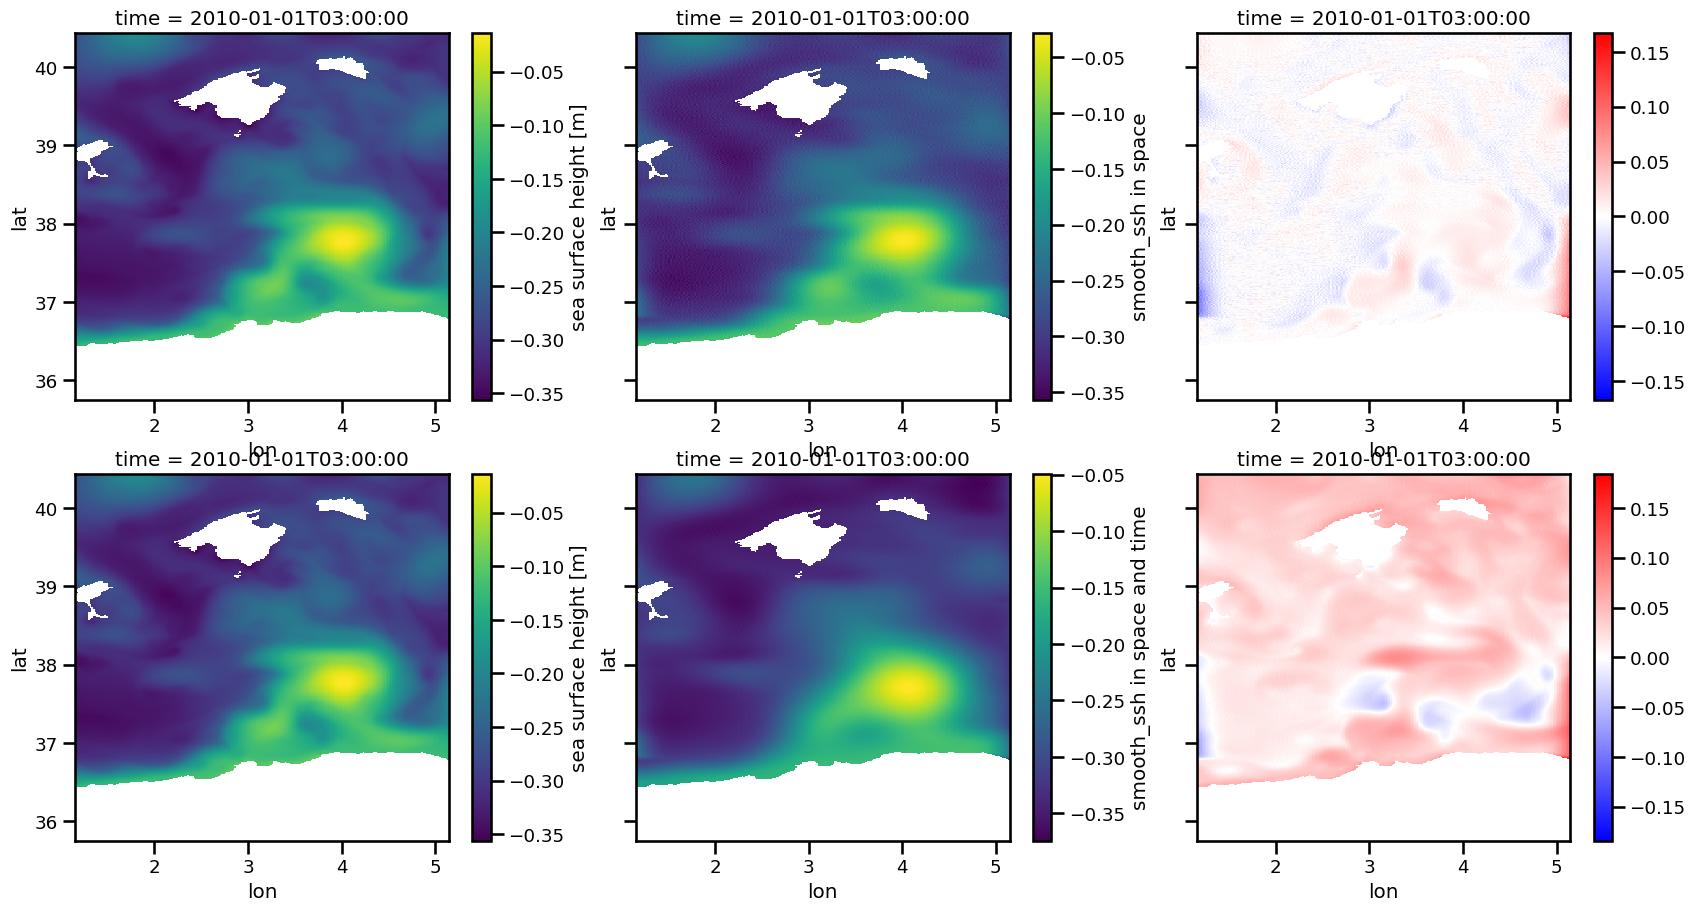

In [8]:
plt.rcParams["figure.figsize"] = [20.50, 10.50]
f, ax = plt.subplots(2, 3, sharey=True)

eNATL[vari][0,:,:].plot(ax=ax[0,0],x='lon', y='lat')
eNATL[varis][0,:,:].plot(ax=ax[0,1],x='lon', y='lat')
difff=eNATL[vari]-eNATL[varis]
difff[0,:,:].plot(ax=ax[0,2],x='lon', y='lat',cmap='bwr')
eNATL[vari][0,:,:].plot(ax=ax[1,0],x='lon', y='lat')
eNATL[variss][0,:,:].plot(ax=ax[1,1],x='lon', y='lat')
difff=eNATL[vari]-eNATL[variss]
difff[0,:,:].plot(ax=ax[1,2],x='lon', y='lat',cmap='bwr')

plt.show()

eNATL[vari] = eNATL[vari].fillna(0)
eNATL[varis] = eNATL[varis].fillna(0)
eNATL[variss] = eNATL[variss].fillna(0)
eeNATL=eNATL

In [9]:
min_lon = 1.3 
min_lat = 37 
max_lon = 5 
max_lat = 38.5 
eNATL = eeNATL.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
#cropped_ds['ssh_s'][1,:,:].plot()
#plt.show()


### Load and display   SEALEVEL_EUR_PHY_L4_MY_008_068


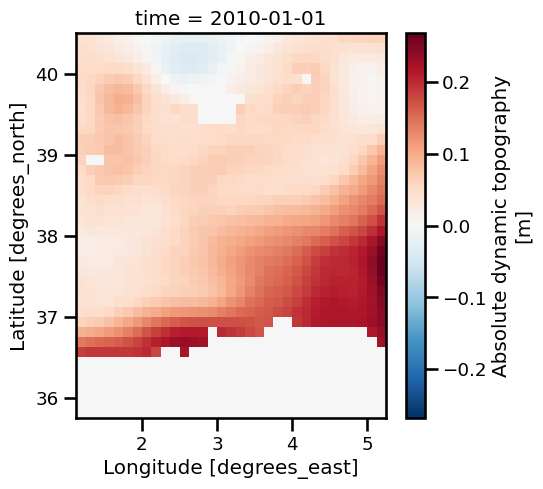

In [10]:
from mpsd import *
from myfuncts2  import *

L4 = xr.open_mfdataset('data/SSHL4.nc')

filter25km =create_filter(10000)

ssh="adt"

plt.rcParams["figure.figsize"] = [5, 5]
f, ax = plt.subplots(1, 1, sharey=True)
L4=L4.rename({'longitude': 'lon','latitude': 'lat'})


L4[ssh] = L4[ssh].fillna(0)
L4[ssh][0,:,:].plot(ax=ax,x='lon', y='lat')
plt.show()
L4 = L4.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))


### Computer PSD in space and time

In [414]:
signal_L4= L4[ssh].chunk({"lat":1, 'time': L4['time'].size, 'lon': L4['lon'].size})
signal_L4['time'] = (signal_L4.time - signal_L4.time[0]) / numpy.timedelta64(1, 'D')
psd_signal_L4 = xrft.power_spectrum(signal_L4, dim=['time','lon'], detrend='linear', window=True).compute()
mean_psd_signal_L4 = psd_signal_L4.mean(dim=['lat']).where( (psd_signal_L4.freq_time > 0) &(psd_signal_L4.freq_lon > 0), drop=True)

signal_eNATL= eNATL[vari].chunk({"lat":1, 'time': eNATL['time'].size, 'lon': eNATL['lon'].size})
signal_eNATL['time'] = (signal_eNATL.time - signal_eNATL.time[0]) / numpy.timedelta64(1, 'D')
psd_signal_eNATL = xrft.power_spectrum(signal_eNATL, dim=['time','lon'], detrend='linear', window=True ).compute()
mean_psd_signal_eNATL = psd_signal_eNATL.mean(dim=['lat']).where( (psd_signal_eNATL.freq_time > 0)&(psd_signal_eNATL.freq_lon > 0), drop=True)


signal_seNATL= eNATL[variss].chunk({"lat":1, 'time': eNATL['time'].size, 'lon': eNATL['lon'].size})
signal_seNATL['time'] = (signal_seNATL.time - signal_seNATL.time[0]) / numpy.timedelta64(1, 'D')
psd_signal_seNATL = xrft.power_spectrum(signal_seNATL, dim=['time','lon'], detrend='linear', window=True, truncatebool=True).compute()
mean_psd_signal_seNATL = psd_signal_seNATL.mean(dim=['lat']).where( (psd_signal_seNATL.freq_time > 0)&(psd_signal_seNATL.freq_lon > 0), drop=True)

mean_psd_signal_eNATL_lon = mean_psd_signal_eNATL.mean("freq_time")
mean_psd_signal_seNATL_lon = mean_psd_signal_seNATL.mean("freq_time")
mean_psd_signal_L4_lon = mean_psd_signal_L4.mean("freq_time")

mean_psd_signal_eNATL_time = mean_psd_signal_eNATL.mean("freq_lon")
mean_psd_signal_seNATL_time = mean_psd_signal_seNATL.mean("freq_lon")
mean_psd_signal_L4_time = mean_psd_signal_L4.mean("freq_lon")

13 32 102


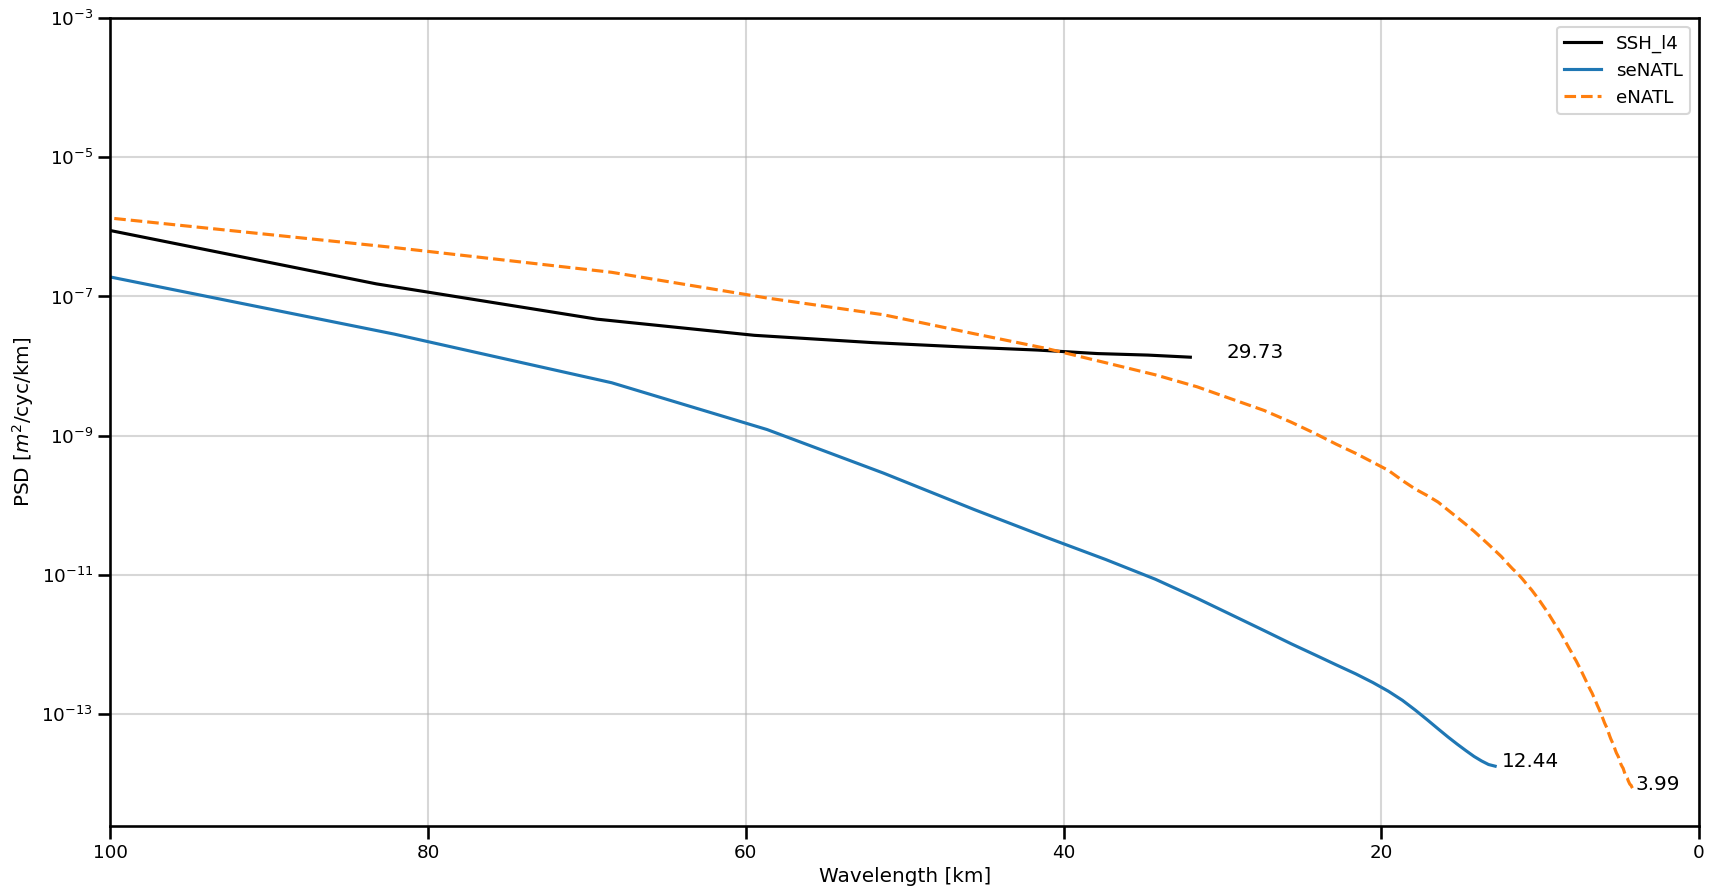

In [415]:
plt.rcParams["figure.figsize"] = [20.50, 10.50]


f, (ax1) = plt.subplots(1, 1, sharey=True)
mini1=np.where(mean_psd_signal_L4_lon==mean_psd_signal_L4_lon.values.min())[0][0]
ax1.plot(1/mean_psd_signal_L4_lon.freq_lon[0:mini1]*111,mean_psd_signal_L4_lon[0:mini1], 'k', label='SSH_l4')
mini2=np.where(mean_psd_signal_seNATL_lon==mean_psd_signal_seNATL_lon.values.min())[0][0]
ax1.plot(1/mean_psd_signal_seNATL_lon.freq_lon[0:mini2]*111,mean_psd_signal_seNATL_lon[0:mini2],label='seNATL')
mini3=np.where(mean_psd_signal_eNATL_lon==mean_psd_signal_eNATL_lon.values.min())[0][0]
ax1.plot(1/mean_psd_signal_eNATL_lon.freq_lon[0:mini3]*111,mean_psd_signal_eNATL_lon[0:mini3],'--',label='eNATL')
ax1.set_ylabel('PSD [$m^2$/cyc/km]')
ax1.set_xlabel('Wavelength [km]')
ax1.grid(which="both", alpha=0.5)  
ax1.legend()
ax1.set_yscale('log')
ax1.set_xlim([0, 100])
ax1.invert_xaxis()
ymin, ymax = ax1.get_ylim()
#ax1.vlines(x=[1/mean_psd_signal_L4_lon.freq_lon[mini1-1]*111,1/mean_psd_signal_eNATL_lon.freq_lon[mini2]*111, 1/mean_psd_signal_eNATL_lon.freq_lon[mini3]*111], ymin=ymin, ymax=ymax, colors=['k','k', 'k'], ls='-', lw=2, alpha=0.5)
ax1.text(1/mean_psd_signal_L4_lon.freq_lon[mini1]*111, mean_psd_signal_L4_lon[mini1], str(round(1/mean_psd_signal_L4_lon.freq_lon[mini1].values*111,2)))
ax1.text(1/mean_psd_signal_eNATL_lon.freq_lon[mini3]*111, mean_psd_signal_eNATL_lon[mini3], str(round(1/mean_psd_signal_eNATL_lon.freq_lon[mini3].values*111,2)))
ax1.text(1/mean_psd_signal_seNATL_lon.freq_lon[mini2]*111, mean_psd_signal_seNATL_lon[mini2], str(round(1/mean_psd_signal_seNATL_lon.freq_lon[mini2].values*111,2)))
print(mini1, mini2, mini3)

plt.show()    


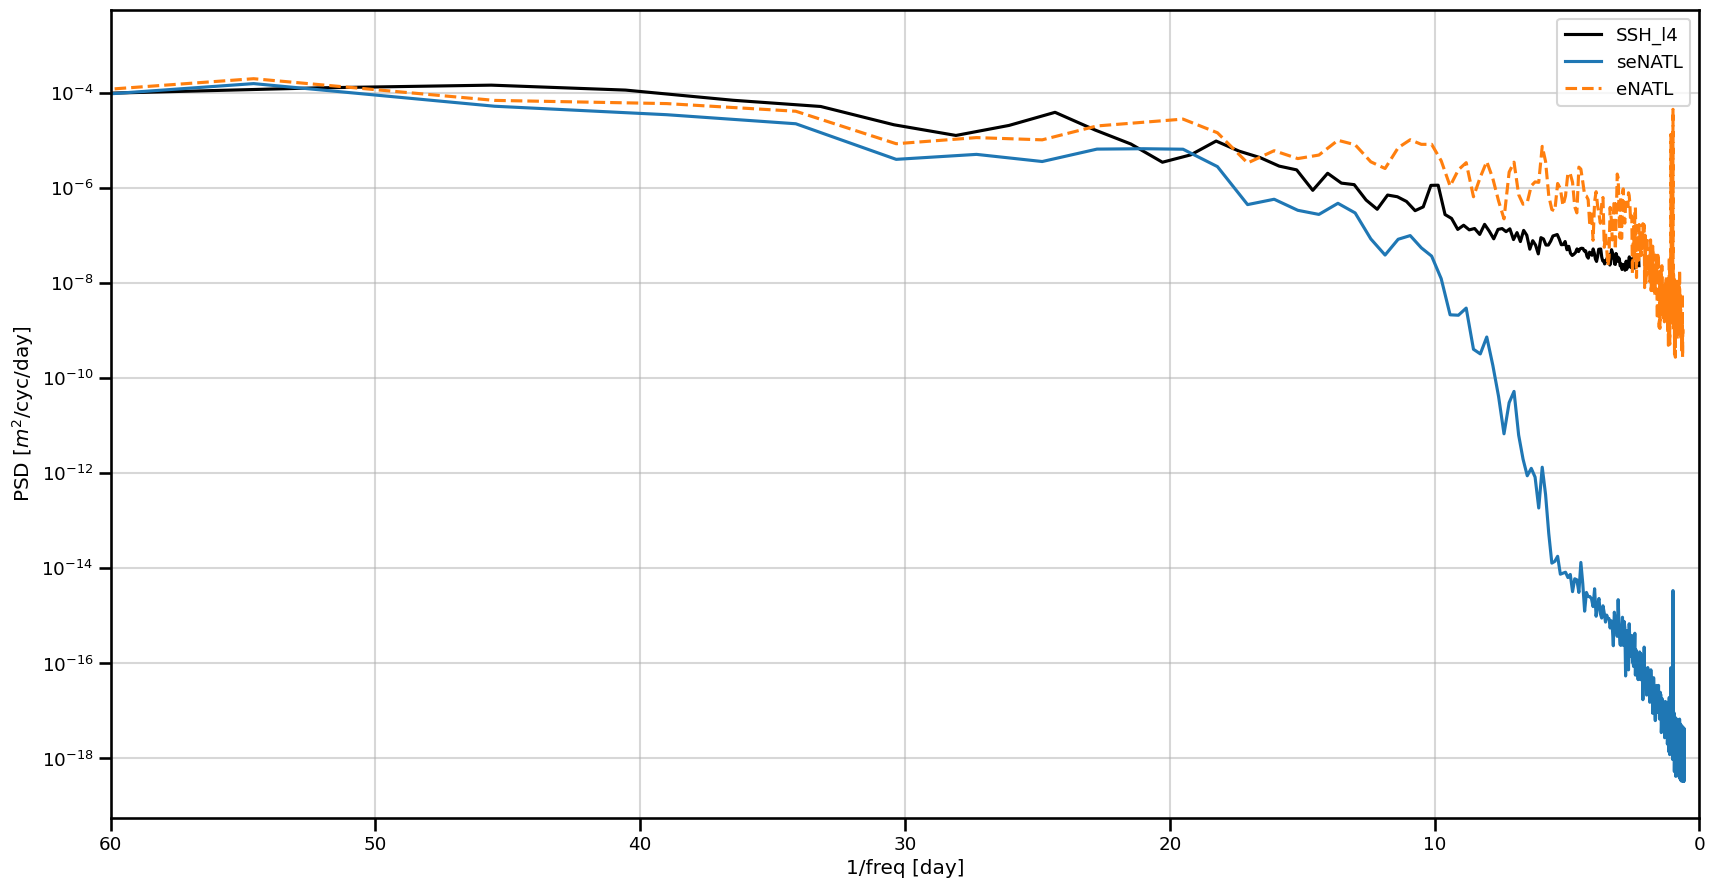

In [416]:
plt.rcParams["figure.figsize"] = [20.50, 10.50]

f, (ax1) = plt.subplots(1, 1, sharey=True)
mini1=np.where(mean_psd_signal_L4_time==mean_psd_signal_L4_time.values.min())[0][0]
ax1.plot(1/mean_psd_signal_L4_time.freq_time[0:mini1],mean_psd_signal_L4_time[0:mini1], 'k', label='SSH_l4')
mini2=np.where(mean_psd_signal_seNATL_time==mean_psd_signal_seNATL_time.values.min())[0][0]
ax1.plot(1/mean_psd_signal_seNATL_time.freq_time[0:mini2],mean_psd_signal_seNATL_time[0:mini2],label='seNATL')
mini3=np.where(mean_psd_signal_eNATL_time==mean_psd_signal_eNATL_time.values.min())[0][0]
ax1.plot(1/mean_psd_signal_eNATL_time.freq_time[0:mini3],mean_psd_signal_eNATL_time[0:mini3],'--',label='eNATL')
ax1.set_ylabel('PSD [$m^2$/cyc/day]')
ax1.set_xlabel('1/freq [day]')
ax1.grid(which="both", alpha=0.5)  
ax1.legend()
ax1.set_yscale('log')
ax1.set_xlim([0, 60])
ax1.invert_xaxis()
# ax1.text(1/mean_psd_signal_L4_time.freq_time[mini1], mean_psd_signal_L4_time[mini1], str(round(1/mean_psd_signal_L4_time.freq_time[mini1].values,2)))
# ax1.text(1/mean_psd_signal_eNATL_time.freq_time[mini3], mean_psd_signal_eNATL_time[mini3], str(round(1/mean_psd_signal_eNATL_time.freq_time[mini3].values,2)))
# ax1.text(1/mean_psd_signal_seNATL_time.freq_time[mini2], mean_psd_signal_seNATL_time[mini2], str(round(1/mean_psd_signal_seNATL_time.freq_time[mini2].values,2)))
plt.show()    


### Isotropic power spectra


In [417]:
signal_seNATL= eNATL[variss]#.chunk({"lat":1, 'time': eNATL['time'].size, 'lon': eNATL['lon'].size})
signal_seNATL['time'] = (signal_seNATL.time - signal_seNATL.time[0]) / numpy.timedelta64(1, 'D')
psd_signal_seNATL = xrft.isotropic_power_spectrum(signal_seNATL, dim=['lat','lon'], detrend='linear', nfactor=4, truncate=True)
psd_signal_seNATL.coords['wavenumber'] = ('freq_r', psd_signal_seNATL['freq_r'].data)
psd_signal_seNATL.rename('Spatial spectrum')
mean_psd_signal_seNATL = psd_signal_seNATL.mean(dim='time').compute()


signal_L4= L4[ssh]#.chunk({"lat":1, 'time': eNATL['time'].size, 'lon': eNATL['lon'].size})
signal_L4['time'] = (signal_L4.time - signal_L4.time[0]) / numpy.timedelta64(1, 'D')
psd_signal_L4 = xrft.isotropic_power_spectrum(signal_L4, dim=['lat','lon'], detrend='linear', nfactor=4, truncate=True)
psd_signal_L4.coords['wavenumber'] = ('freq_r', psd_signal_L4['freq_r'].data)
psd_signal_L4.rename('Spatial spectrum')
mean_psd_signal_L4 = psd_signal_L4.mean(dim='time').compute()

signal_eNATL= eNATL[vari]#.chunk({"lat":1, 'time': eNATL['time'].size, 'lon': eNATL['lon'].size})
signal_eNATL['time'] = (signal_eNATL.time - signal_eNATL.time[0]) / numpy.timedelta64(1, 'D')
psd_signal_eNATL = xrft.isotropic_power_spectrum(signal_eNATL, dim=['lat','lon'], detrend='linear', nfactor=4, truncate=True)
psd_signal_eNATL.coords['wavenumber'] = ('freq_r', psd_signal_eNATL['freq_r'].data)
psd_signal_eNATL.rename('Spatial spectrum')
mean_psd_signal_eNATL = psd_signal_eNATL.mean(dim='time').compute()


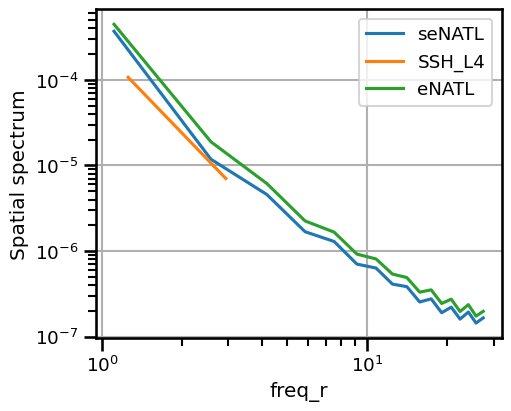

In [418]:
fig, ax = plt.subplots(ncols=1, constrained_layout=True, figsize=(5,4))
mean_psd_signal_seNATL.plot(x='freq_r', ax=ax, ls='-', marker='', label='seNATL')
mean_psd_signal_L4.plot(x='freq_r', ax=ax, ls='-', marker='', label='SSH_L4')
mean_psd_signal_eNATL.plot(x='freq_r', ax=ax, ls='-', marker='', label='eNATL')
ax.set(xscale='log', yscale='log'); ax.grid(True)
ax.set_ylabel('Spatial spectrum')

ax.legend()
plt.show()